In [41]:
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import ast
from typing import List, Tuple

from collections import defaultdict
from typing import List                                                                                                         
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc
# 30 sec

In [42]:
from Enum.EnergyRange import EnergyRange
from Enum.Flavour import Flavour

In [43]:
sys.path.append('/groups/icecube/cyan/Utils')
from PlotUtils import setMplParam, getColour, getHistoParam 
# getHistoParam:
# Nbins, binwidth, bins, counts, bin_centers  = 
from DB_lister import list_content, list_tables
from ExternalFunctions import nice_string_output, add_text_to_ax
setMplParam()

## they all have $W^O$ in the attention layer

In [44]:
csvs = {
    ## "linear,sdp, 128, rep1(078)" :"/lustre/hpc/icecube/cyan/factory/IceCubeTransformer/predictions/20250430/model_20250429_094410/102142/predictions_epoch_078_val_loss_0.1355.csv",
    ## "linear,sdp, 128, rep2(099)" :"/lustre/hpc/icecube/cyan/factory/IceCubeTransformer/predictions/20250430/model_20250429_094410/102142/predictions_epoch_last_val_loss_last.csv",
    ## "linear,x, 128, rep1(016)" :"/lustre/hpc/icecube/cyan/factory/IceCubeTransformer/predictions/20250502/model_20250502_093718/153916/predictions_epoch_016_val_loss_0.1266.csv",
    ## "ReLU,x, 128, rep2(015)" :"/lustre/hpc/icecube/cyan/factory/IceCubeTransformer/predictions/20250503/model_20250503_135838/175246/predictions_epoch_015_val_loss_0.1268.csv",
    ## "1ReLU,x, 256, (018)" :"/lustre/hpc/icecube/cyan/factory/IceCubeTransformer/predictions/20250503/model_20250503_145447/175323/predictions_epoch_018_val_loss_0.1219.csv",
    ## "2ReLU,x, 256, (018)" :"/lustre/hpc/icecube/cyan/factory/IceCubeTransformer/predictions/20250503/model_20250503_183326/213650/predictions_epoch_021_val_loss_0.1236.csv",
    ## "4ReLU,x, 256, (013)" :"/lustre/hpc/icecube/cyan/factory/IceCubeTransformer/predictions/20250504/model_20250504_121205/135144/predictions_epoch_013_val_loss_0.1234.csv",
    ## "4SiLU,x, 256, (030)":"/lustre/hpc/icecube/cyan/factory/IceCubeTransformer/predictions/20250504/model_20250504_164551/235737/predictions_epoch_030_val_loss_0.1174.csv",
    "4SiLU,x, 256, (049)":"/lustre/hpc/icecube/cyan/factory/IceCubeTransformer/predictions/20250504/model_20250504_164551/235737/predictions_epoch_last_val_loss_last.csv",
    ## "8SiLU,x, 256, (034)":"/lustre/hpc/icecube/cyan/factory/IceCubeTransformer/predictions/20250505/model_20250504_233119/111005/predictions_epoch_034_val_loss_0.1238.csv",
    "8SiLU,x, 256, (049)":"/lustre/hpc/icecube/cyan/factory/IceCubeTransformer/predictions/20250505/model_20250504_233119/111005/predictions_epoch_last_val_loss_last.csv",
    ## "8SiLU,x, 256,1, val blend(034)":"/lustre/hpc/icecube/cyan/factory/IceCubeTransformer/predictions/20250505/model_20250504_233119/112239/predictions_epoch_034_val_loss_0.1238.csv",
    # "8SiLU,x, 256,1, val blend,(049)":"/lustre/hpc/icecube/cyan/factory/IceCubeTransformer/predictions/20250505/model_20250504_233119/112239/predictions_epoch_last_val_loss_last.csv",
    # "8SiLU,x, 256,2, val blend,(036)":"/lustre/hpc/icecube/cyan/factory/IceCubeTransformer/predictions/20250505/model_20250505_112153/191542/predictions_epoch_036_val_loss_0.1194.csv",
    # "8SiLU,x, 256,2, val blend,(048)":"/lustre/hpc/icecube/cyan/factory/IceCubeTransformer/predictions/20250505/model_20250505_112153/191542/predictions_epoch_048_val_loss_0.1196.csv",
    "8SiLU,x, 256,2, val blend,(065)":"/lustre/hpc/icecube/cyan/factory/IceCubeTransformer/predictions/20250505/model_20250505_112153/191542/predictions_epoch_065_val_loss_0.1375.csv",
    "8SiLU,x, 256,2, val blend,(?)":"/lustre/hpc/icecube/cyan/factory/IceCubeTransformer/predictions/20250505/model_20250505_112153/191542/predictions_epoch_last_val_loss_last.csv",
    # "8SiLU,x, 256,2, val blend,(099)": "/lustre/hpc/icecube/cyan/factory/IceCubeTransformer/predictions/20250505/model_20250505_112153/225245/predictions_epoch_last_val_loss_last.csv",
    "8SiLU,x,256,rope,1,val blend,(005)":"/lustre/hpc/icecube/cyan/factory/IceCubeTransformer/predictions/20250506/model_20250505_225104/093823/predictions_epoch_005_val_loss_0.1177.csv",
    "8SiLU,x,256,rope,2,val blend,(006)" : "/lustre/hpc/icecube/cyan/factory/IceCubeTransformer/predictions/20250506/model_20250505_225425/094947/predictions_epoch_006_val_loss_0.1209.csv",
    }

In [45]:
def get_nu_logits(df: pd.DataFrame, flavour: Flavour) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    def safe_parse(x):
        return ast.literal_eval(x) if isinstance(x, str) else x

    df["logits"] = df["logits"].apply(safe_parse)

    nu_e = df[df["target_class"] == 0]
    nu_mu = df[df["target_class"] == 1]
    nu_tau = df[df["target_class"] == 2]

    index = 0 if flavour == Flavour.E else 1 if flavour == Flavour.MU else 2 if flavour == Flavour.TAU else None

    if index is None:
        raise ValueError(f"Unknown flavour: {flavour}")

    nu_e_logit = nu_e["logits"].apply(lambda x: x[index]).to_numpy()
    nu_mu_logit = nu_mu["logits"].apply(lambda x: x[index]).to_numpy()
    nu_tau_logit = nu_tau["logits"].apply(lambda x: x[index]).to_numpy()
    
    return nu_e_logit, nu_mu_logit, nu_tau_logit


In [46]:
def fraction_above_threshold(arr: np.ndarray, threshold: float = 0.9) -> float:
    return np.mean(arr > threshold)

In [47]:
def plot_multi_flavour_ROC(df: pd.DataFrame, id: str) -> None:
    fig, ax = plt.subplots(figsize=(17, 11))

    ref_fpr = None
    ref_thresholds = None

    for colour_i, flavour in [(2, Flavour.E), (0, Flavour.MU), (1, Flavour.TAU)]:
        nu_e_logit, nu_mu_logit, nu_tau_logit = get_nu_logits(df, flavour)

        y_true = np.concatenate([
            np.ones_like(nu_e_logit) if flavour == Flavour.E else np.zeros_like(nu_e_logit),
            np.ones_like(nu_mu_logit) if flavour == Flavour.MU else np.zeros_like(nu_mu_logit),
            np.ones_like(nu_tau_logit) if flavour == Flavour.TAU else np.zeros_like(nu_tau_logit),
        ])
        y_score = np.concatenate([nu_e_logit, nu_mu_logit, nu_tau_logit])

        fpr, tpr, thresholds = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)

        ax.plot(fpr, tpr, label=fr"${flavour.latex}$ (AUC = {roc_auc:.3f})",
                linewidth=2, color=getColour(colour_i), markersize=1)

        if ref_fpr is None and ref_thresholds is None:
            ref_fpr = fpr
            ref_thresholds = thresholds

    ax.plot([0, 1], [0, 1], 'k--', linewidth=1)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(fr"ROC Curves by Flavour, {id}")
    ax.legend(loc="lower right", fontsize=16)

    # Custom top axis for selected logit values
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())

    # Manually chosen logit values
    manual_thresholds = [0.9, 0.75, 0.5, 0.25, 0.1, 0.0]

    # Match each logit threshold to closest FPR index
    ref_thresholds = np.array(ref_thresholds)
    ref_fpr = np.array(ref_fpr)
    tick_indices = [np.argmin(np.abs(ref_thresholds - t)) for t in manual_thresholds]

    ax2.set_xticks(ref_fpr[tick_indices])
    ax2.set_xticklabels([f"{t:.2f}" for t in manual_thresholds])
    ax2.set_xlabel("Logit Thresholds")


In [48]:
def plot_logit_distribution(df: pd.DataFrame, 
                            flavour: Flavour,
                            id: str,
                            manifier: Tuple[float, float] = None) -> None:
    nu_e_logit, nu_mu_logit, nu_tau_logit = get_nu_logits(df, flavour)
    Nbins, binwidth, bins, counts, bin_centers = getHistoParam(nu_tau_logit, binwidth=0.005)
    fig, ax = plt.subplots(figsize=(17, 11))
    ax.hist(nu_e_logit, bins=bins, label=fr"${Flavour.E.latex}$", color=getColour(2), histtype='step', linewidth=1)
    ax.hist(nu_mu_logit, bins=bins, label=fr"${Flavour.MU.latex}$", color=getColour(0), histtype='step', hatch='\\', linewidth=1)
    ax.hist(nu_tau_logit, bins=bins, label=fr"${Flavour.TAU.latex}$", color=getColour(1), histtype='step', hatch ='//', linewidth=1)
    
    ax.set_title(fr"${flavour.latex}$ logit Distribution, {id}")
    ax.set_xlabel('Logit')
    ax.set_ylabel('Counts')
    
    max_logit = np.max([np.max(nu_e_logit), np.max(nu_mu_logit), np.max(nu_tau_logit)])
    threshold = 0.9 * max_logit
    abs_threshold = 0.85

    if manifier:
        ax.set_xlim(manifier)
    else:
        ax.set_xlim(-0.1, 1.1)
    d_e = {
        r'$\nu_e$': "",
        "N": len(nu_e_logit),
        "max": np.max(nu_e_logit),
        "min": np.min(nu_e_logit),
        "mean": np.mean(nu_e_logit),
        "median": np.median(nu_e_logit),
        f"frac>{threshold:.3f}": fraction_above_threshold(nu_e_logit, threshold),
        f"frac>{abs_threshold:.3f}": fraction_above_threshold(nu_e_logit, abs_threshold),
        }
    d_mu = {
        r'$\nu_\mu$': "",
        "N": len(nu_mu_logit),
        "max": np.max(nu_mu_logit),
        "min": np.min(nu_mu_logit),
        "mean": np.mean(nu_mu_logit),
        "median": np.median(nu_mu_logit),
        f"frac>{threshold:.3f}": fraction_above_threshold(nu_mu_logit, threshold),
        f"frac>{abs_threshold:.3f}": fraction_above_threshold(nu_mu_logit, abs_threshold),
        }
    d_tau = {
        r'$\nu_\tau$': "",
        "N": len(nu_tau_logit),
        "max": np.max(nu_tau_logit),
        "min": np.min(nu_tau_logit),
        "mean": np.mean(nu_tau_logit),
        "median": np.median(nu_tau_logit),
        f"frac>{threshold:.3f}": fraction_above_threshold(nu_tau_logit, threshold),
        f"frac>{abs_threshold:.3f}": fraction_above_threshold(nu_tau_logit, abs_threshold),
        }
    x_annot = 0.30 if manifier else 0.45 
    y_annot = 0.95
    y_annot_offset = 0.23
    add_text_to_ax(x_annot, y_annot, nice_string_output(d_e), ax, fontsize=12)
    add_text_to_ax(x_annot, y_annot-y_annot_offset, nice_string_output(d_mu), ax, fontsize=12)
    add_text_to_ax(x_annot, y_annot-y_annot_offset*2, nice_string_output(d_tau), ax, fontsize=12)

    ax.legend(fontsize=20)

In [49]:
def plot_csvs(csvs:dict, is_magnifier_on:bool):
    for id, csv in csvs.items():
        df = pd.read_csv(csv)
        # plot_logit_distribution(df, Flavour.E, id)
        # if is_magnifier_on:
        #     plot_logit_distribution(df, Flavour.E, id, manifier=(0.8, 1.0))
        # plot_logit_distribution(df, Flavour.MU, id)
        # if is_magnifier_on:
            # plot_logit_distribution(df, Flavour.MU, id, manifier=(0.8, 1.0))
        plot_logit_distribution(df, Flavour.TAU, id)
        # if is_magnifier_on:
        #     plot_logit_distribution(df, Flavour.TAU, id, manifier=(0.8, 1.1))
        plot_multi_flavour_ROC(df, id)

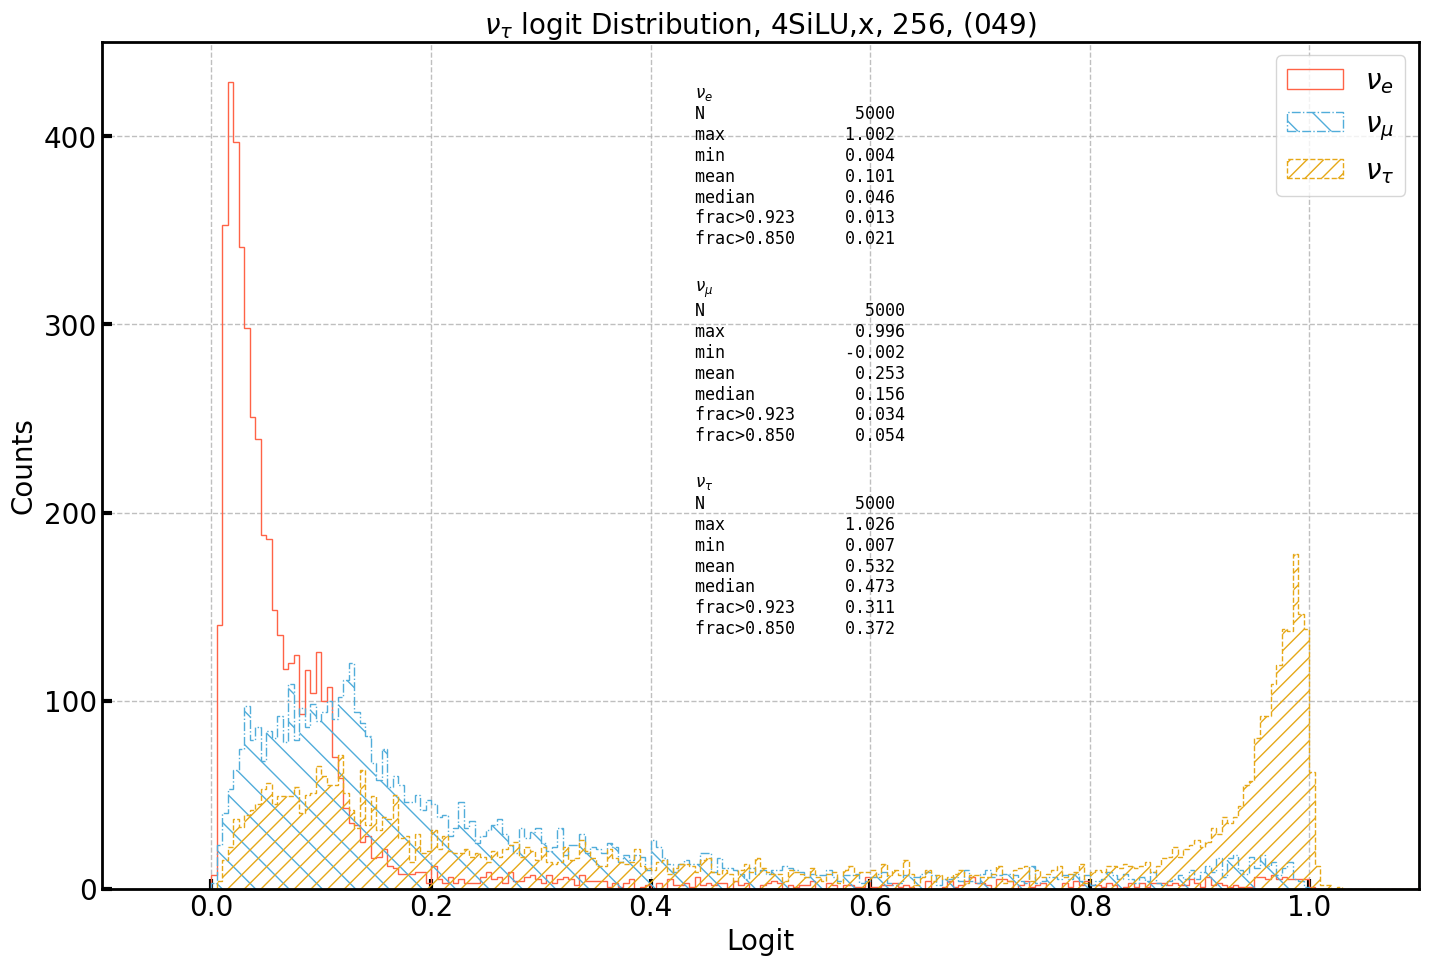

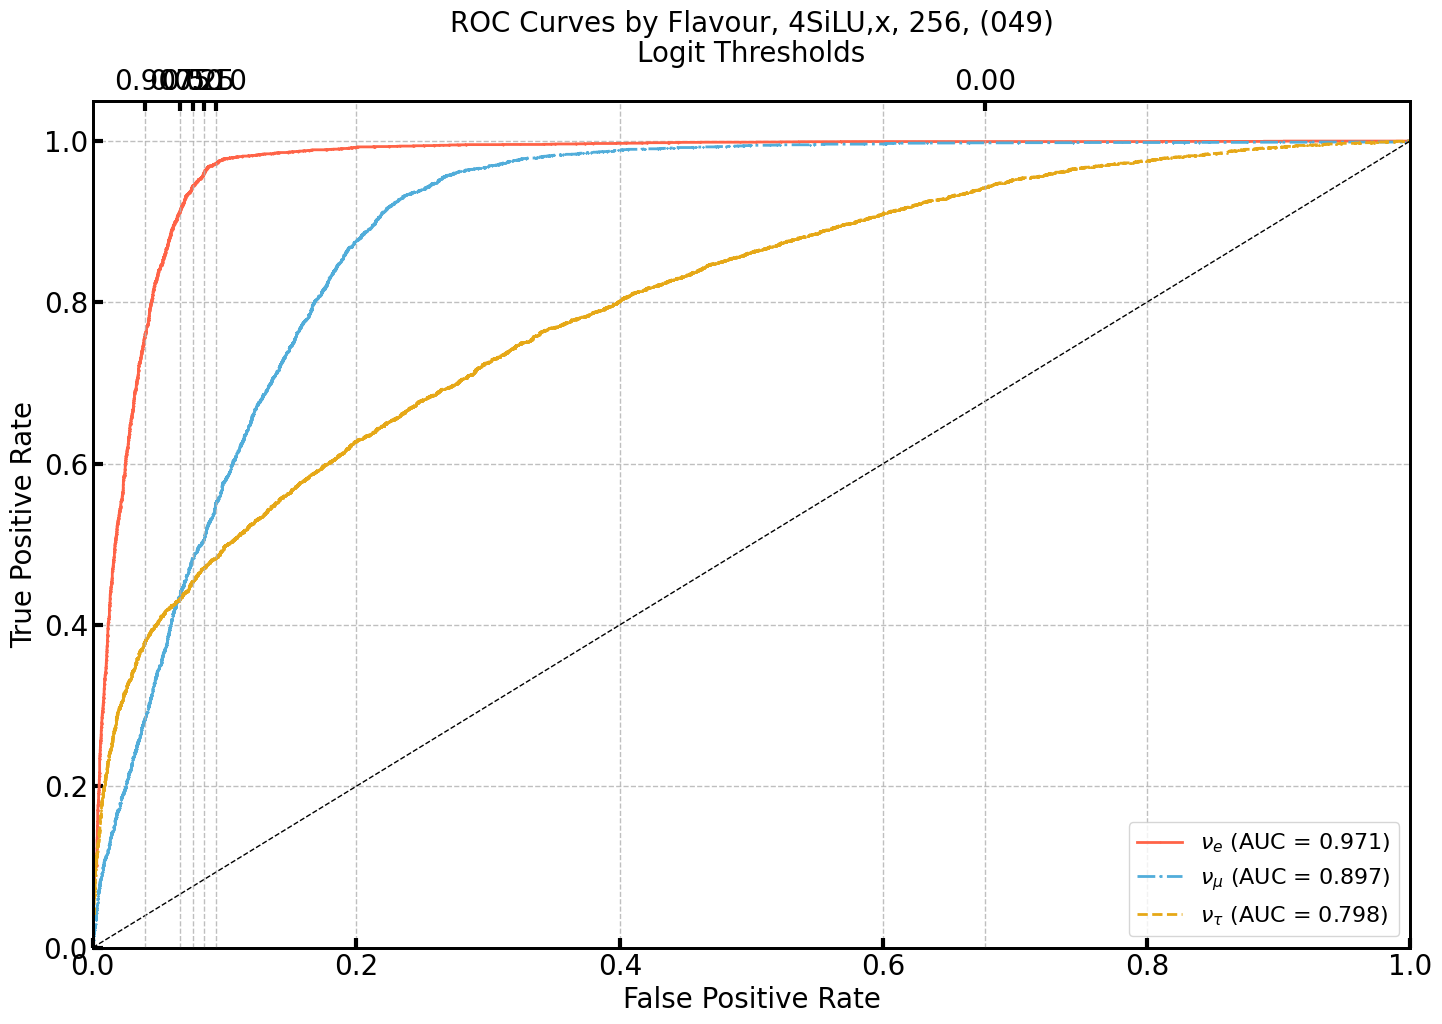

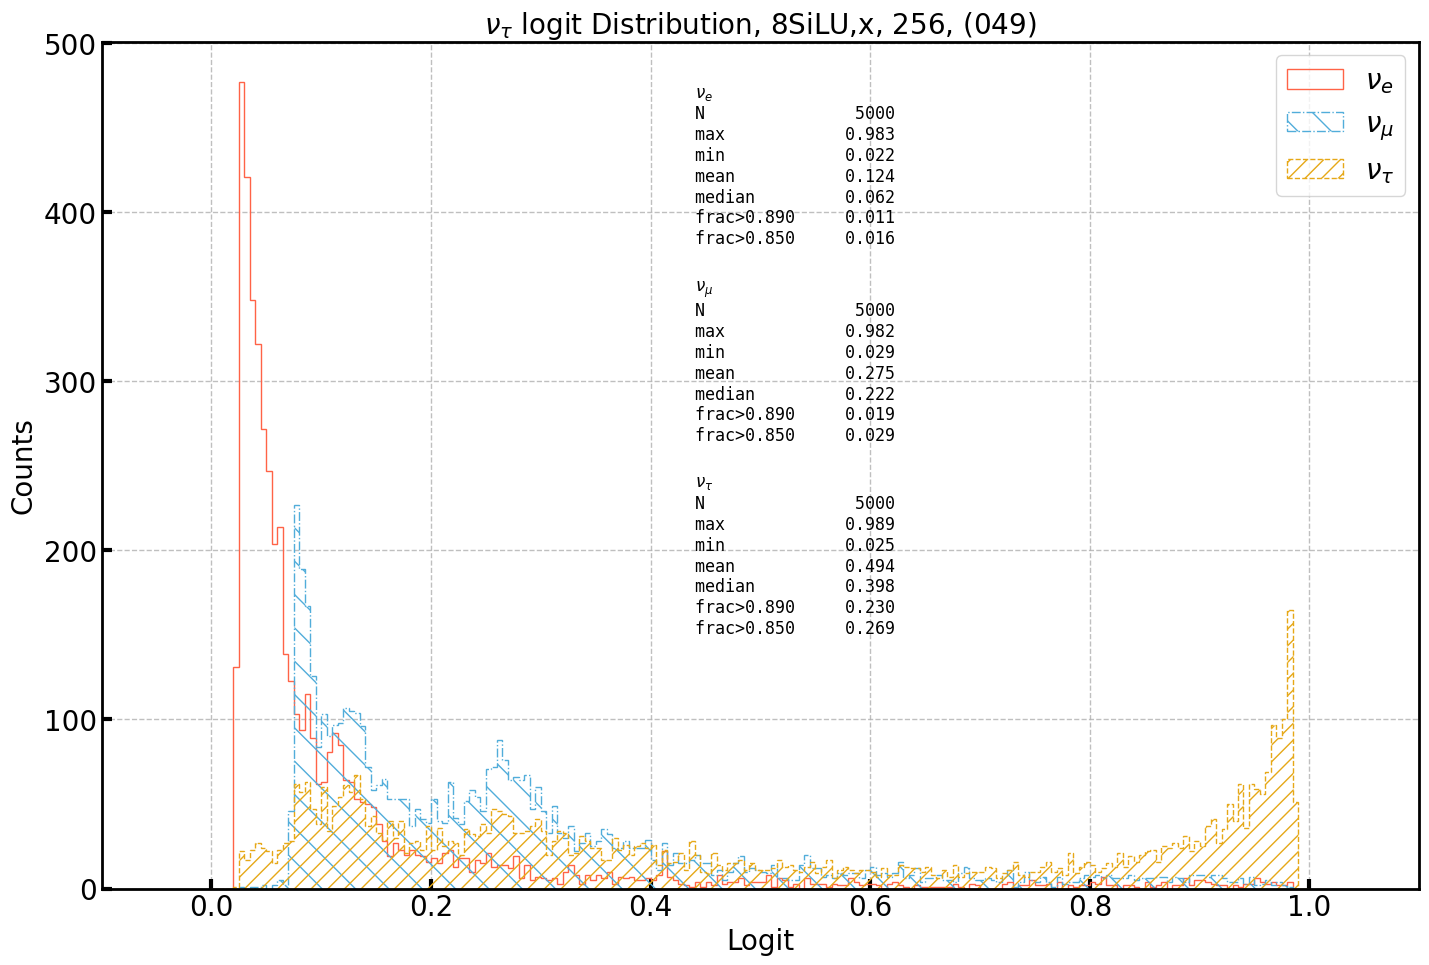

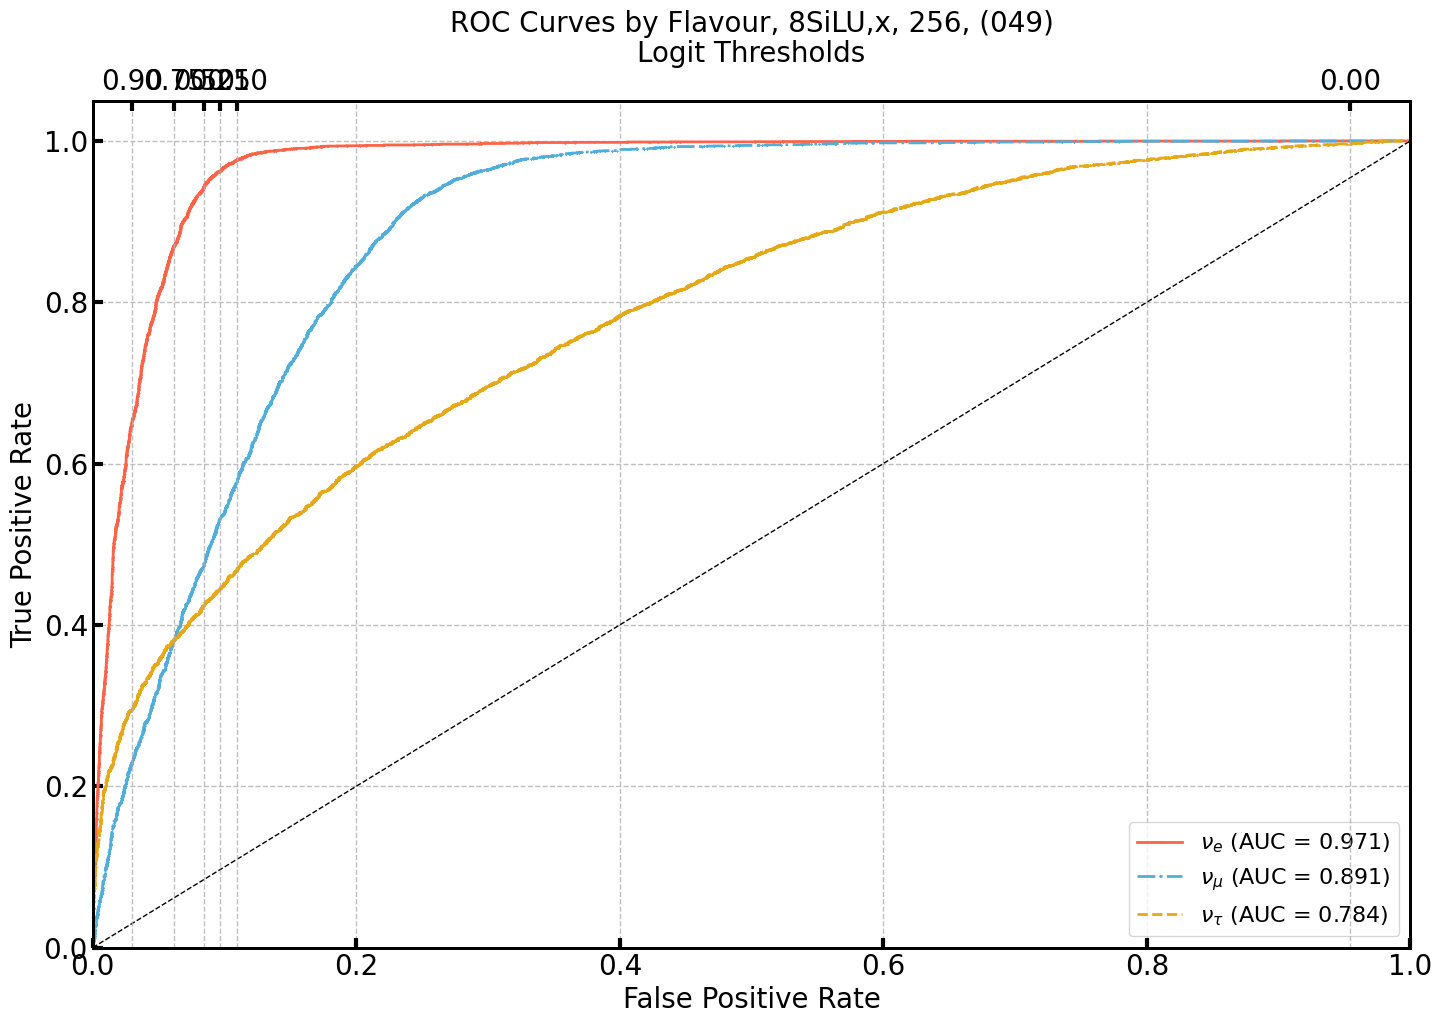

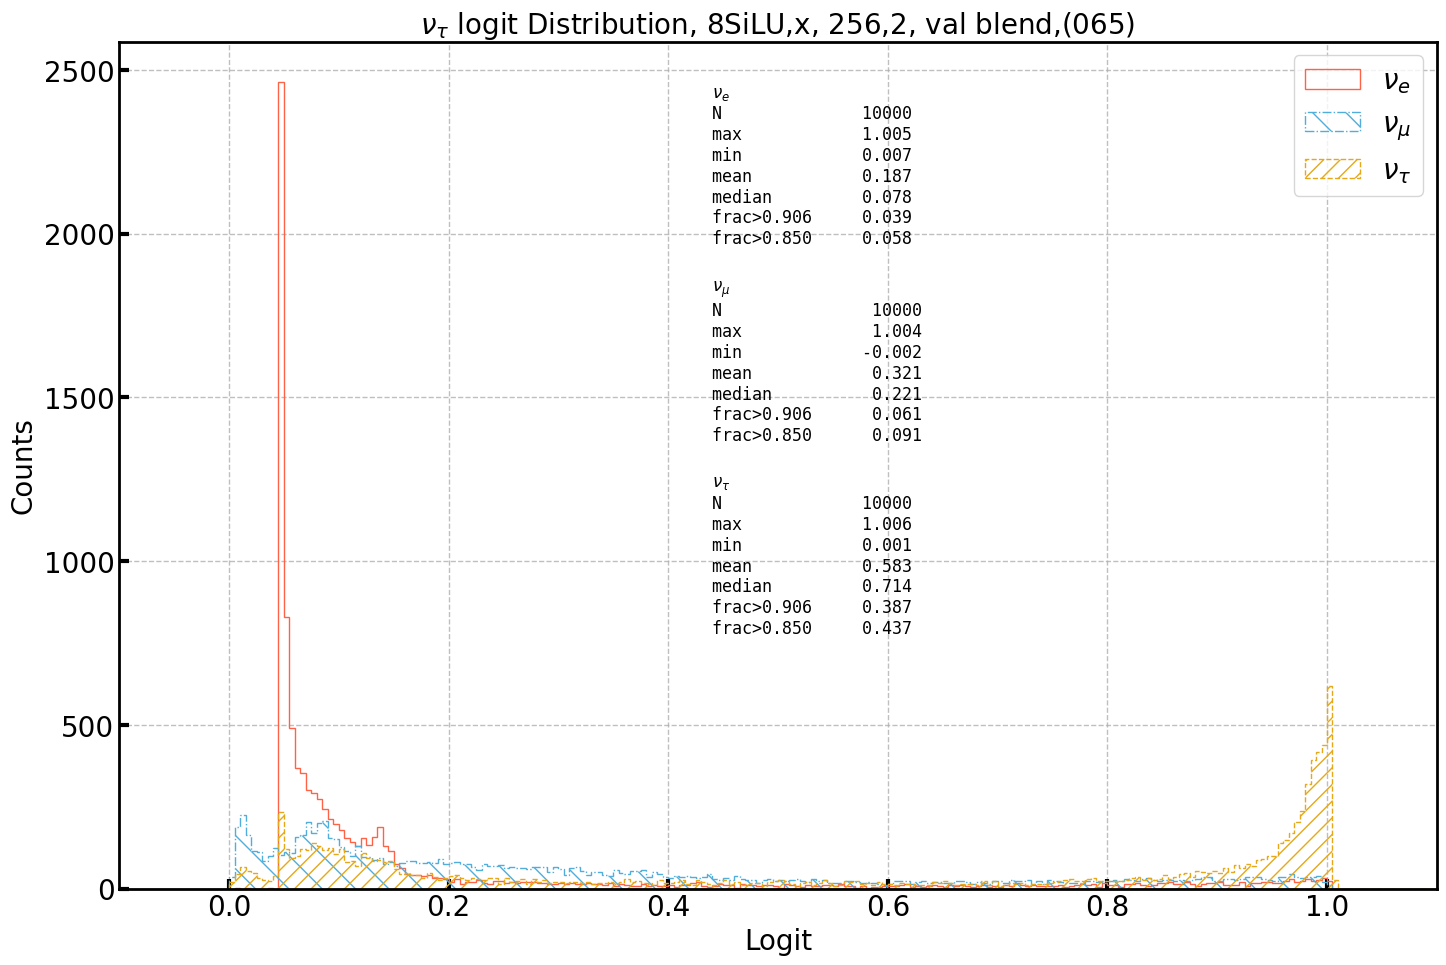

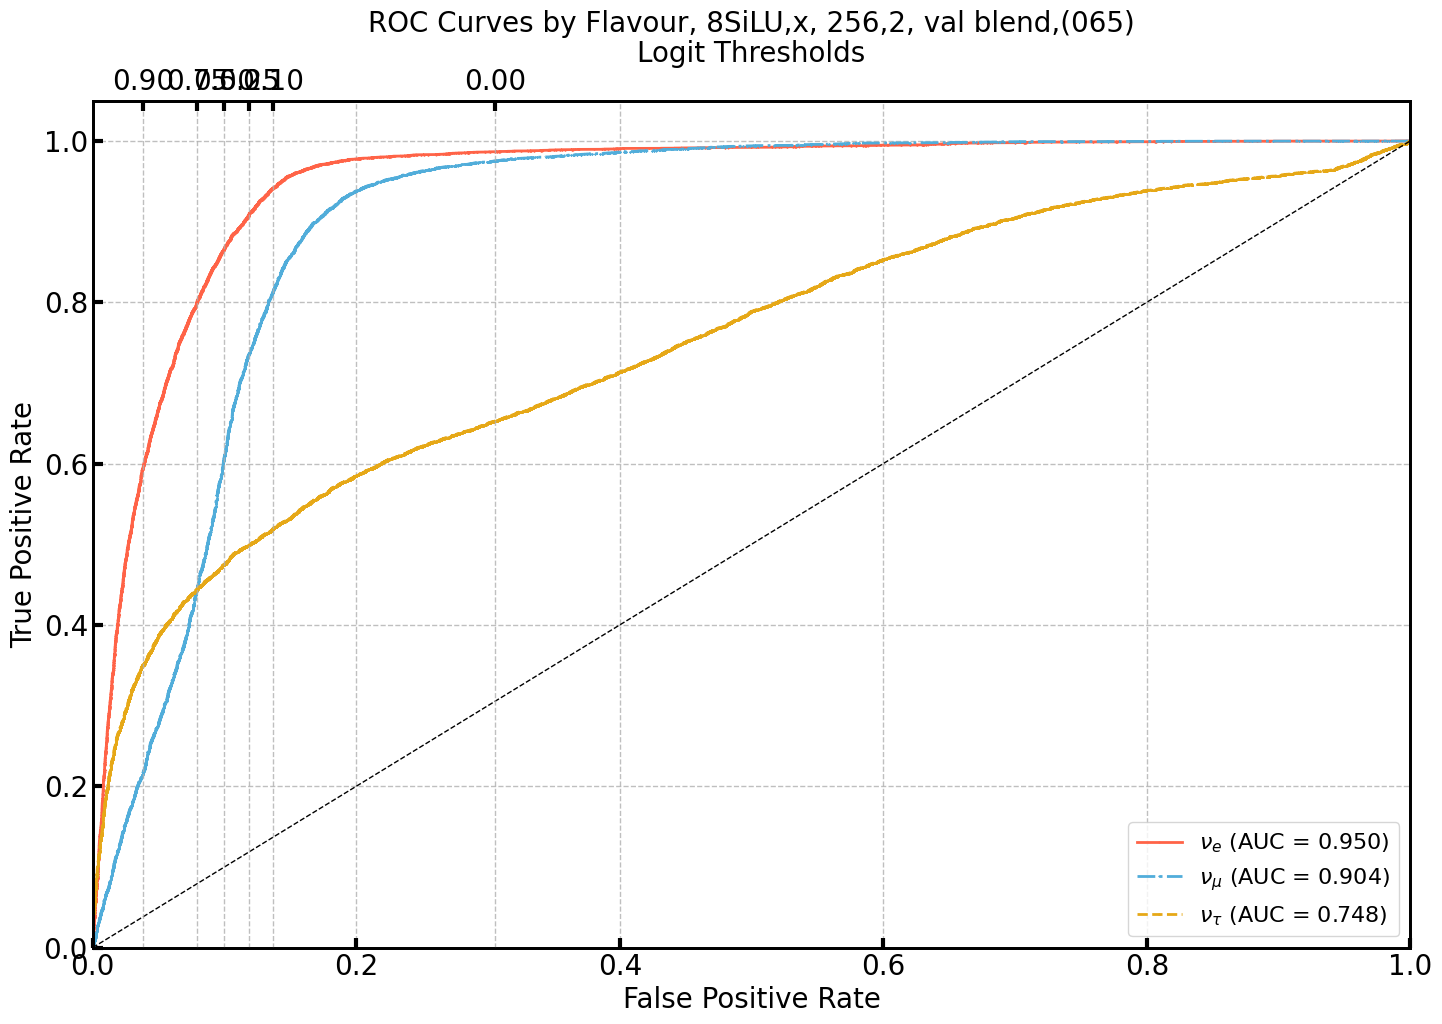

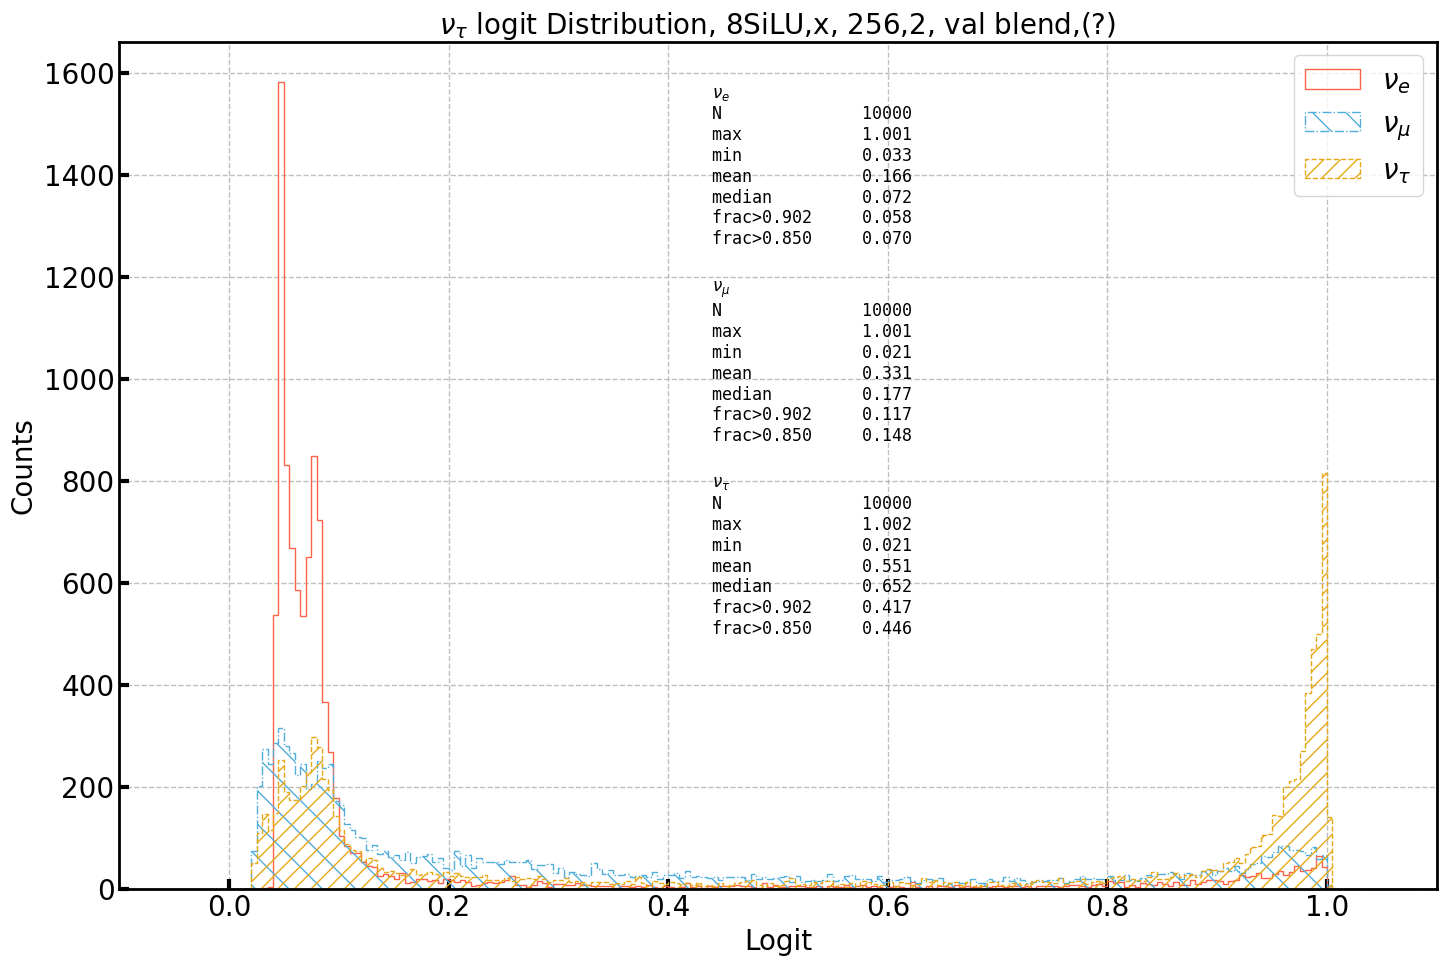

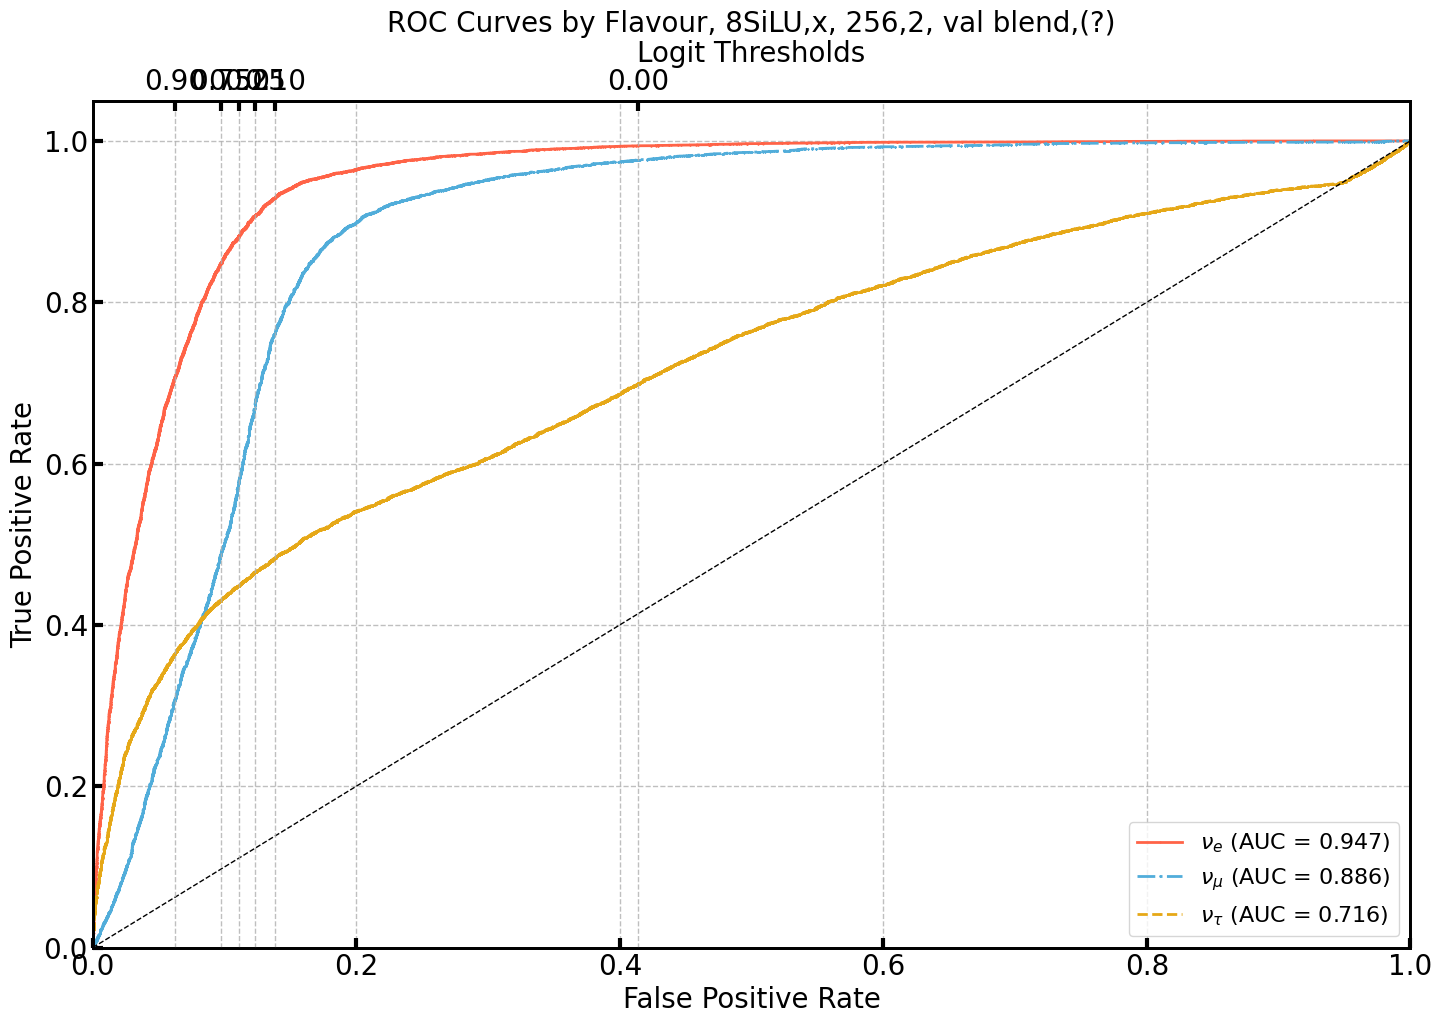

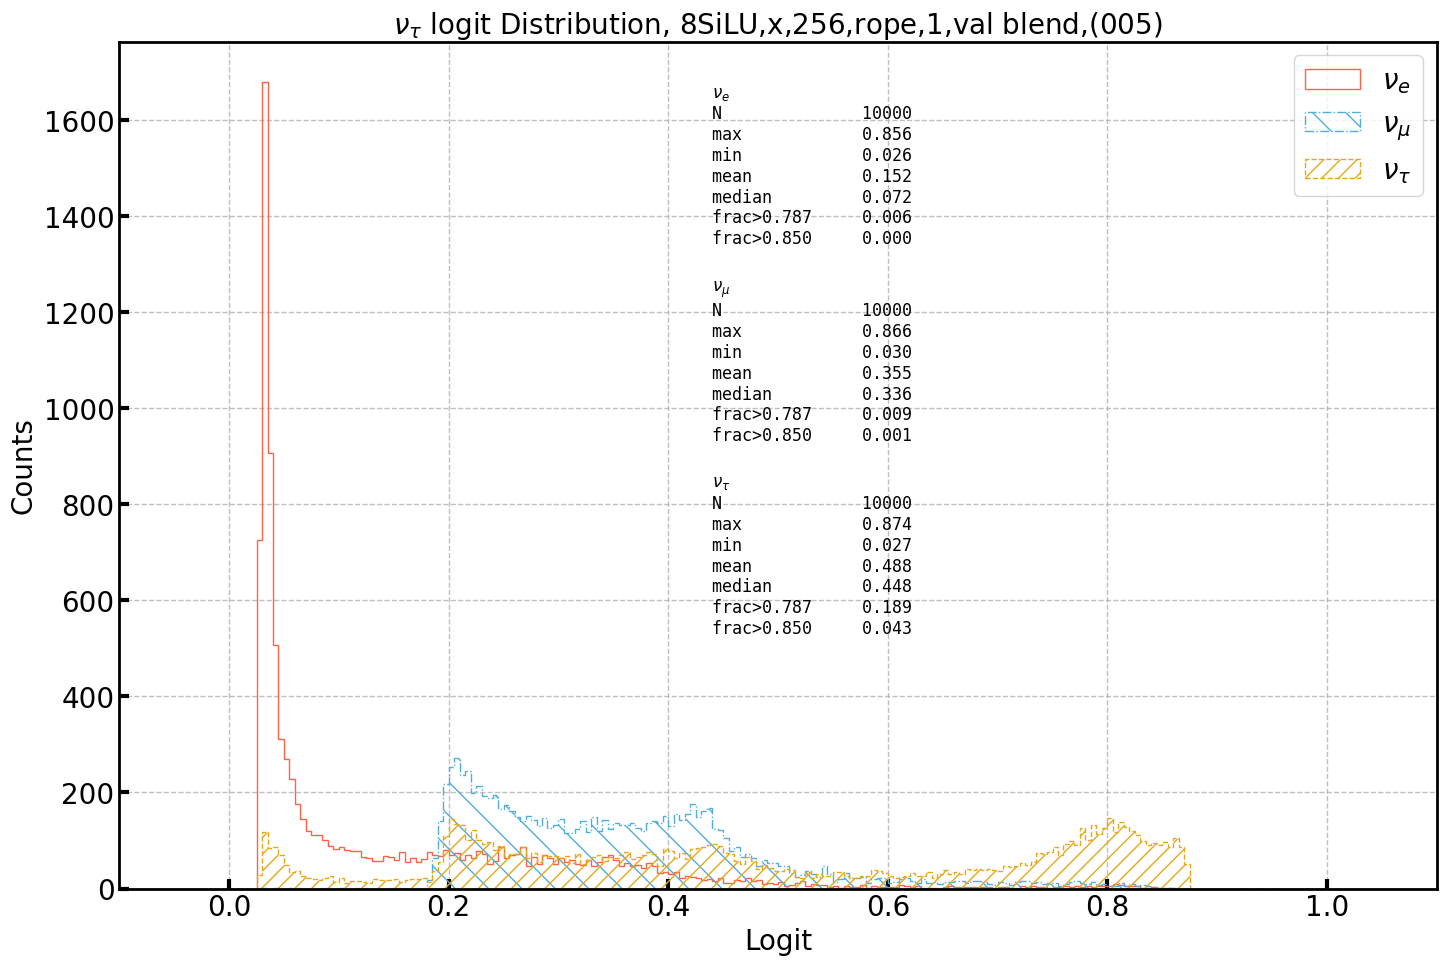

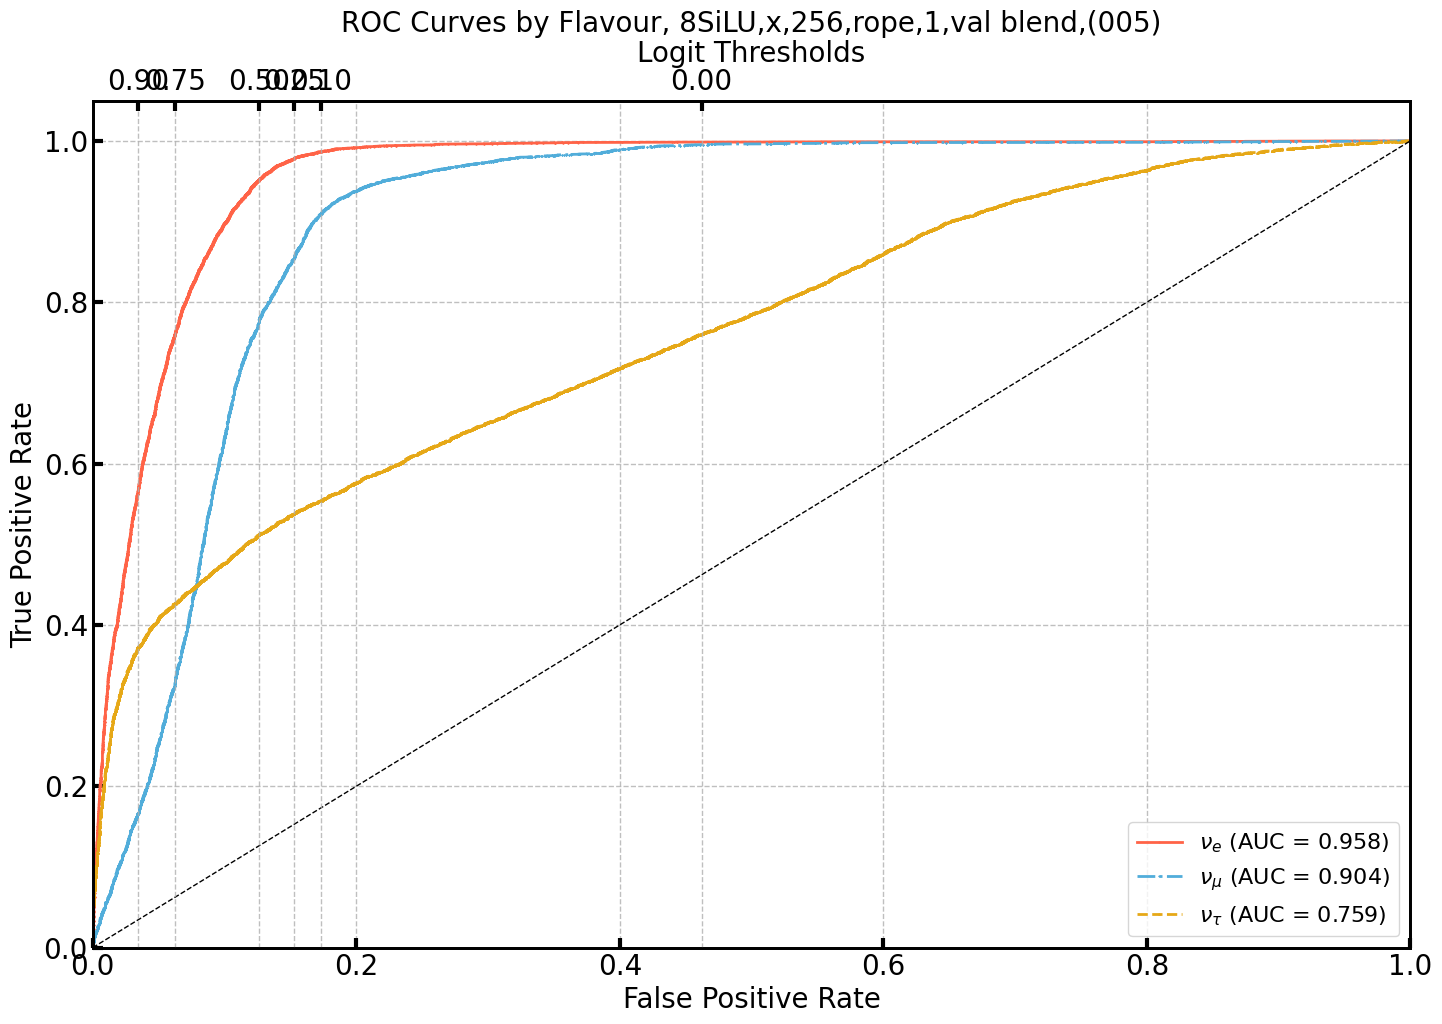

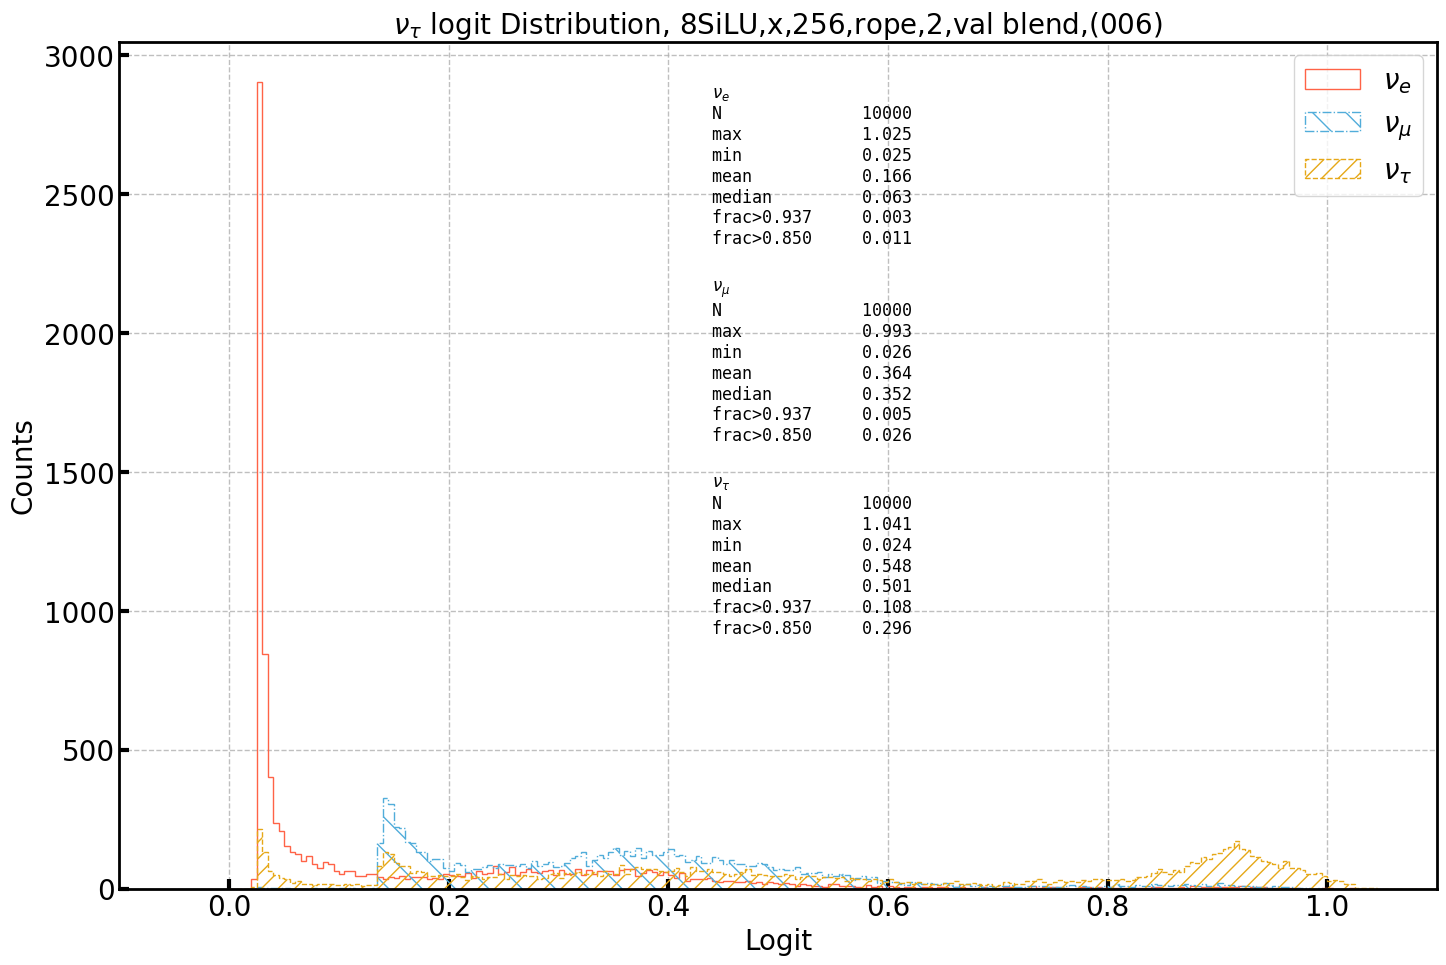

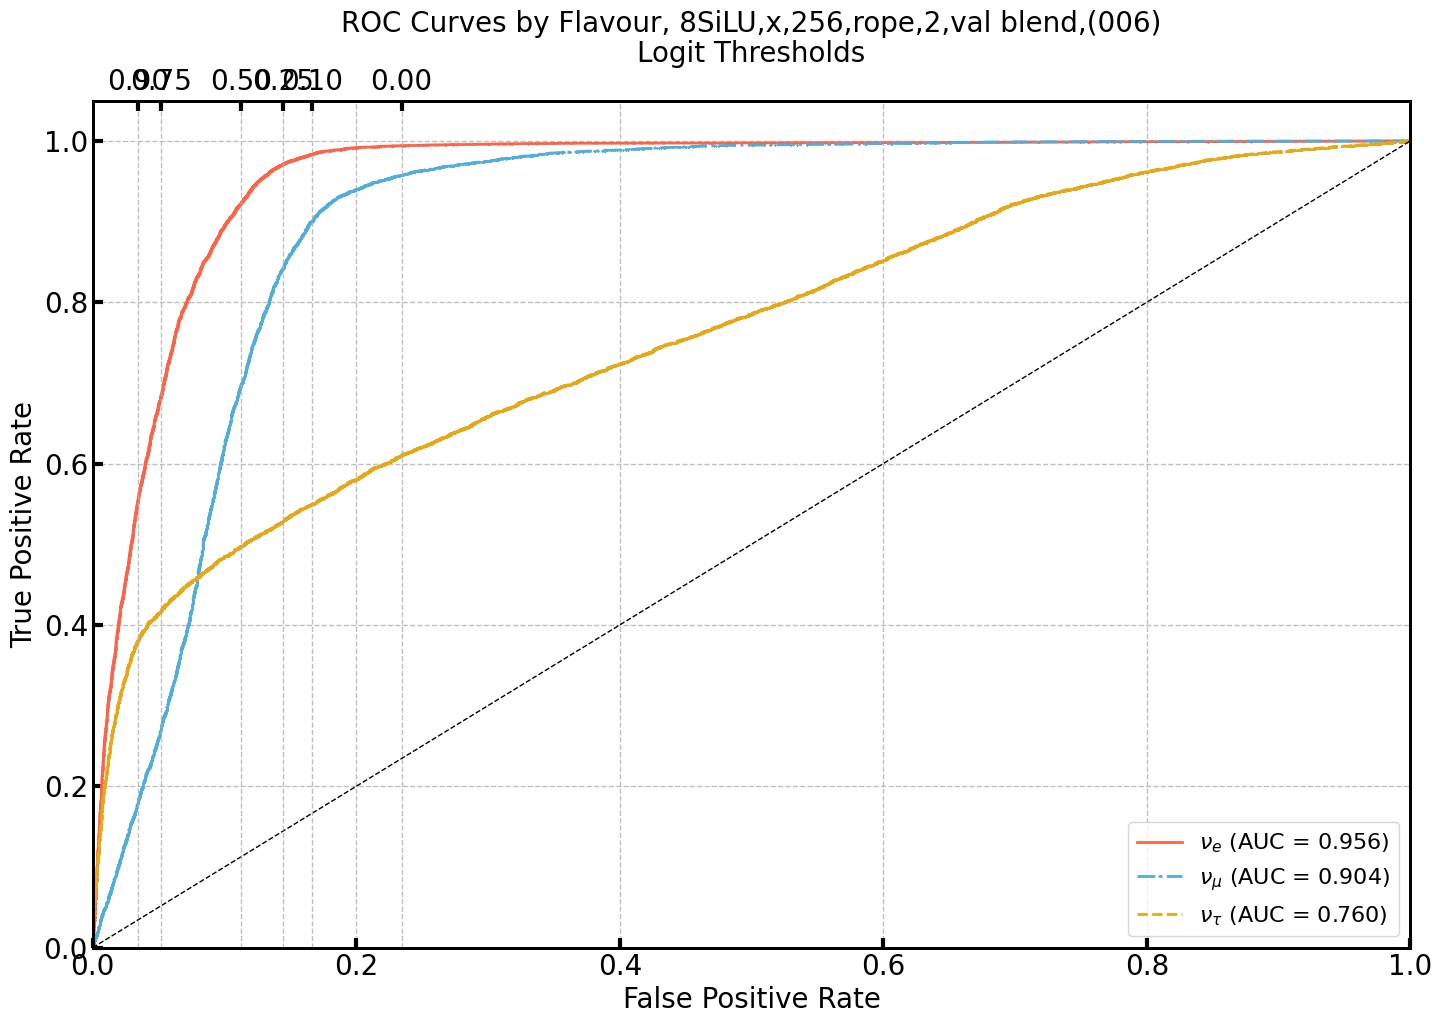

In [50]:
plot_csvs(csvs, is_magnifier_on=True)

In [51]:
def get_energy(df: pd.DataFrame, flavour: Flavour) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    def safe_parse(x):
        return ast.literal_eval(x) if isinstance(x, str) else x

    df["energy"] = df["energy"].apply(safe_parse)

    nu_e = df[df["target_class"] == 0]
    nu_mu = df[df["target_class"] == 1]
    nu_tau = df[df["target_class"] == 2]

    index = 0 if flavour == Flavour.E else 1 if flavour == Flavour.MU else 2 if flavour == Flavour.TAU else None

    if index is None:
        raise ValueError(f"Unknown flavour: {flavour}")

    nu_e_energy = nu_e["energy"].to_numpy()
    nu_mu_energy = nu_mu["energy"].to_numpy()
    nu_tau_energy = nu_tau["energy"].to_numpy()

    return nu_e_energy, nu_mu_energy, nu_tau_energy

In [52]:
def get_zenith(df:pd.DataFrame, flavour:Flavour) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    def safe_parse(x):
        return ast.literal_eval(x) if isinstance(x, str) else x

    df["zenith"] = df["zenith"].apply(safe_parse) # in radian

    nu_e = df[df["target_class"] == 0]
    nu_mu = df[df["target_class"] == 1]
    nu_tau = df[df["target_class"] == 2]

    index = 0 if flavour == Flavour.E else 1 if flavour == Flavour.MU else 2 if flavour == Flavour.TAU else None

    if index is None:
        raise ValueError(f"Unknown flavour: {flavour}")
    nu_e_zenith = nu_e["zenith"].to_numpy()
    nu_mu_zenith = nu_mu["zenith"].to_numpy()
    nu_tau_zenith = nu_tau["zenith"].to_numpy()
    nu_e_zenith = np.rad2deg(nu_e_zenith)
    nu_mu_zenith = np.rad2deg(nu_mu_zenith)
    nu_tau_zenith = np.rad2deg(nu_tau_zenith)
    return nu_e_zenith, nu_mu_zenith, nu_tau_zenith

In [53]:
def plot_energy_logit_distribution_mono_flavour(nu_logit : np.ndarray,
                                                energy: np.ndarray,
                                                logit_flavour: Flavour,
                                                flavour: Flavour, 
                                                energy_range: EnergyRange,
                                                id: str,
                                                normalise_by_energy: bool = True) -> None:
    Nbins, binwidth, bins, counts, bin_centers = getHistoParam(nu_logit, binwidth=0.1)
    log_energy_binwidth = 0.25
    log_energy = np.log10(energy)
    log_energy_bin = np.arange(np.min(log_energy), np.max(log_energy), log_energy_binwidth)

    # Get raw counts before normalisation
    raw_counts, xedges, yedges = np.histogram2d(nu_logit, log_energy, bins=[bins, log_energy_bin])
    H = raw_counts.copy()

    if normalise_by_energy:
        # Normalise each energy bin (i.e. column-wise)
        H = H / (H.sum(axis=0, keepdims=True) + 1e-8)  # Avoid division by zero

    fig, ax = plt.subplots(figsize=(17, 11))
    mesh = ax.pcolormesh(xedges, yedges, H.T, cmap='YlGnBu', shading='auto')

    fig.colorbar(mesh, ax=ax, label="Counts" if not normalise_by_energy else "Counts normalised within energy bin")
    ax.set_title(fr"Energy–logit ${logit_flavour.latex}$ distribution of true ${flavour.latex}$, {id}")
    ax.set_xlabel('Logit')
    ax.set_ylabel('log(Energy[GeV])')
    ax.set_xlim(-0.1, 1.0)

    # Set energy range limits
    if energy_range == EnergyRange.ER_1_PEV_100_PEV:
        log_energy_min = 6
        log_energy_max = 8
    elif energy_range == EnergyRange.ER_10_TEV_1_PEV:
        log_energy_min = 4
        log_energy_max = 6
    elif energy_range == EnergyRange.ER_100_GEV_10_TEV:
        log_energy_min = 2
        log_energy_max = 4   
    elif energy_range == EnergyRange.ER_100_TEV_100_PEV:
        log_energy_min = 5
        log_energy_max = 8
    ax.set_ylim(log_energy_min, log_energy_max)

    # Annotate bin centres with adaptive text colour
    max_norm = np.max(H)
    xcentres = 0.5 * (xedges[:-1] + xedges[1:])
    ycentres = 0.5 * (yedges[:-1] + yedges[1:])
    for i in range(len(xcentres)):
        for j in range(len(ycentres)):
            count = raw_counts[i, j]
            norm = H[i, j]
            if count > 0:
                # Brighter bins get white text
                relative_intensity = norm / max_norm
                text_colour = 'white' if relative_intensity > 0.5 else 'black'
                ax.text(xcentres[i], ycentres[j], f"{int(count)}\n({norm:.2f})",
                        ha='center', va='center', fontsize=8, color=text_colour)
                
        # Add total counts for each energy bin (i.e. each column)
    energy_bin_totals = raw_counts.sum(axis=0)  # Sum over x-axis bins

    # Get position of the plot to position text between plot and colourbar
    fig.canvas.draw()
    ax_pos = ax.get_position()
    text_x = ax_pos.x1 + 0.01  # right outside the plot

    # Transform y-centres from data coords → figure coords
    for j, y in enumerate(ycentres):
        display_coord = ax.transData.transform((0, y))       # -> display
        figure_coord = fig.transFigure.inverted().transform(display_coord)  # -> figure

        fig.text(text_x, figure_coord[1], f"{int(energy_bin_totals[j])}",
                 ha='left', va='center', fontsize=10)
    top_y_display = ax.transData.transform((0, yedges[-1]))
    top_y_fig = fig.transFigure.inverted().transform(top_y_display)[1]

    fig.text(text_x, top_y_fig + 0.01, "Total", ha='left', va='bottom', fontsize=10, weight='bold')

In [54]:
def plot_energy_logit_distribution(df: pd.DataFrame, 
                                   flavour: Flavour,
                                   energy_range: EnergyRange,
                                   id: str) -> None:
    nu_e_logit, nu_mu_logit, nu_tau_logit = get_nu_logits(df, flavour)
    e_energy, mu_energy, tau_energy = get_energy(df, flavour)
    
    plot_energy_logit_distribution_mono_flavour(nu_e_logit, e_energy, flavour, Flavour.E, energy_range, id, normalise_by_energy=True)
    plot_energy_logit_distribution_mono_flavour(nu_mu_logit, mu_energy, flavour, Flavour.MU, energy_range, id, normalise_by_energy=True)
    plot_energy_logit_distribution_mono_flavour(nu_tau_logit, tau_energy, flavour, Flavour.TAU, energy_range, id, normalise_by_energy=True)

In [55]:
def plot_csvs_energy(csvs:dict, energy_range: EnergyRange):
    for id, csv in csvs.items():
        df = pd.read_csv(csv)
        plot_energy_logit_distribution(df, Flavour.E, energy_range, id)
        plot_energy_logit_distribution(df, Flavour.MU, energy_range, id)
        plot_energy_logit_distribution(df, Flavour.TAU, energy_range, id)

In [56]:
# plot_csvs_energy(csvs, EnergyRange.ER_100_TEV_100_PEV)

In [57]:
def plot_zenith_logit_distribution_mono_flavour(nu_logit : np.ndarray,
                                                nu_zenith: np.ndarray,
                                                logit_flavour: Flavour,
                                                flavour: Flavour, 
                                                id: str) -> None:
    Nbins, binwidth, bins, counts, bin_centers = getHistoParam(nu_logit, binwidth=0.1)
    zenith_binwidth = 22.5
    zenith_bin = np.arange(0, 180 + zenith_binwidth, zenith_binwidth)

    raw_counts, xedges, yedges = np.histogram2d(nu_logit, nu_zenith, bins=[bins, zenith_bin])
    H = raw_counts / (raw_counts.sum(axis=0, keepdims=True) + 1e-8)  # normalise by zenith bin

    fig, ax = plt.subplots(figsize=(17, 11))
    mesh = ax.pcolormesh(xedges, yedges, H.T, cmap='YlOrBr', shading='auto')

    fig.colorbar(mesh, ax=ax, label="Counts normalised within zenith bin")
    ax.set_title(fr"Zenith–logit ${logit_flavour.latex}$ distribution of true ${flavour.latex}$, {id}")
    ax.set_xlabel('Logit')
    ax.set_ylabel('Zenith [degree]')
    ax.set_xlim(-0.1, 1.0)

    # Annotate bin centres with adaptive colour
    max_norm = np.max(H)
    xcentres = 0.5 * (xedges[:-1] + xedges[1:])
    ycentres = 0.5 * (yedges[:-1] + yedges[1:])
    for i in range(len(xcentres)):
        for j in range(len(ycentres)):
            count = raw_counts[i, j]
            norm = H[i, j]
            if count > 0:
                relative_intensity = norm / max_norm
                text_colour = 'white' if relative_intensity > 0.5 else 'black'
                ax.text(xcentres[i], ycentres[j], f"{int(count)}\n({norm:.2f})",
                        ha='center', va='center', fontsize=8, color=text_colour)


In [58]:
def plot_zenith_logit_distribution(df: pd.DataFrame, 
                                   flavour: Flavour,
                                   id: str) -> None:
    nu_e_logit, nu_mu_logit, nu_tau_logit = get_nu_logits(df, flavour)
    e_zenith, mu_zenith, tau_zenith = get_zenith(df, flavour)
    
    plot_zenith_logit_distribution_mono_flavour(nu_e_logit, e_zenith, flavour, Flavour.E, id)
    plot_zenith_logit_distribution_mono_flavour(nu_mu_logit, mu_zenith, flavour, Flavour.MU, id)
    plot_zenith_logit_distribution_mono_flavour(nu_tau_logit, tau_zenith, flavour, Flavour.TAU, id)

In [59]:
def plot_csvs_zenith(csvs:dict):
    for id, csv in csvs.items():
        df = pd.read_csv(csv)
        print(df['azimuth'].describe())
        plot_zenith_logit_distribution(df, Flavour.E, id)
        plot_zenith_logit_distribution(df, Flavour.MU, id)
        plot_zenith_logit_distribution(df, Flavour.TAU, id)

In [60]:
# plot_csvs_zenith(csvs)